In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
from numpy import arange

In this notebook I'll test things related to the bioassay data

In [11]:
df = pd.read_csv("../01_data/test_data/bioassay_test_data.csv")
df.shape

(148, 6)

In [12]:
df = df.pivot(index=["sample_id", "genotype", "day"], columns="stage", values="number")
df.head()

stage                   early_fourth   egg  exuviae  first  late_fourth  \
sample_id genotype day                                                    
cv_1      cv       2             0.0  50.0      0.0    0.0          0.0   
                   7             0.0   NaN      0.0   20.0          0.0   
                   9             2.0   NaN      0.0   20.0          0.0   
                   12           15.0   NaN      0.0    5.0          5.0   
                   15           15.0   NaN      1.0    0.0          9.0   

stage                   second  third  
sample_id genotype day                 
cv_1      cv       2       0.0    0.0  
                   7       5.0    0.0  
                   9      15.0   10.0  
                   12     10.0   10.0  
                   15      5.0   10.0

In [13]:
df['fourth_exuviae'] = df.exuviae + df.late_fourth
df.head()

stage                   early_fourth   egg  exuviae  first  late_fourth  \
sample_id genotype day                                                    
cv_1      cv       2             0.0  50.0      0.0    0.0          0.0   
                   7             0.0   NaN      0.0   20.0          0.0   
                   9             2.0   NaN      0.0   20.0          0.0   
                   12           15.0   NaN      0.0    5.0          5.0   
                   15           15.0   NaN      1.0    0.0          9.0   

stage                   second  third  fourth_exuviae  
sample_id genotype day                                 
cv_1      cv       2       0.0    0.0             0.0  
                   7       5.0    0.0             0.0  
                   9      15.0   10.0             0.0  
                   12     10.0   10.0             5.0  
                   15      5.0   10.0            10.0

In [14]:
df['fourth_exuviae'] = df.groupby('sample_id')['fourth_exuviae'].cumsum()
df.head()

stage                   early_fourth   egg  exuviae  first  late_fourth  \
sample_id genotype day                                                    
cv_1      cv       2             0.0  50.0      0.0    0.0          0.0   
                   7             0.0   NaN      0.0   20.0          0.0   
                   9             2.0   NaN      0.0   20.0          0.0   
                   12           15.0   NaN      0.0    5.0          5.0   
                   15           15.0   NaN      1.0    0.0          9.0   

stage                   second  third  fourth_exuviae  
sample_id genotype day                                 
cv_1      cv       2       0.0    0.0             0.0  
                   7       5.0    0.0             0.0  
                   9      15.0   10.0             0.0  
                   12     10.0   10.0             5.0  
                   15      5.0   10.0            15.0

In [15]:
grouped_df = df.groupby(level='sample_id')
corrected_df = pd.DataFrame()

for day, group in grouped_df:
    temp_df = group
    temp_df = temp_df.reset_index()
    temp_df['test'] = temp_df['fourth_exuviae']

    for i in range(1, len(temp_df)):
        if temp_df.loc[i-1, 'test'] != 0:
            if temp_df.loc[i, 'test'] < temp_df.loc[i-1, 'test']:
                temp_df.loc[i, 'test'] = temp_df.loc[i-1, 'test']
            else:
                pass
        else:
            pass

    corrected_df = pd.concat([corrected_df, temp_df], ignore_index=True)
    
print(corrected_df)
        
#
#        if temp_df.loc['day', i] == 2:
#            temp_df['test'] = temp_df.fourth_exuviae
#        elif temp_df.fourth_exuviae.loc[i] < temp_df.previous.loc[i]:
#            temp_df['test'] = temp_df.previous
#        else:
#            temp_df['test'] = temp_df.fourth_exuviae
#        
#        print(temp_df)

stage sample_id genotype  day  early_fourth   egg  exuviae  first  \
0          cv_1       cv    2           0.0  50.0      0.0    0.0   
1          cv_1       cv    7           0.0   NaN      0.0   20.0   
2          cv_1       cv    9           2.0   NaN      0.0   20.0   
3          cv_1       cv   12          15.0   NaN      0.0    5.0   
4          cv_1       cv   15          15.0   NaN      1.0    0.0   
5          cv_1       cv   19          10.0   NaN      5.0    0.0   
6          cv_3       cv    2           0.0  55.0      0.0    0.0   
7          cv_3       cv    7           0.0   NaN      0.0   22.0   
8          cv_3       cv    9           2.0   NaN      0.0   20.0   
9          cv_3       cv   12          18.0   NaN      0.0    5.0   
10         cv_3       cv   15          15.0   NaN      3.0    0.0   
11         cv_3       cv   19          10.0   NaN      5.0    0.0   
12       wild_2     wild    2           0.0  60.0      0.0    0.0   
13       wild_2     wild    7     

In [16]:
corrected_df.head()

stage,sample_id,genotype,day,early_fourth,egg,exuviae,first,late_fourth,second,third,fourth_exuviae,test
0,cv_1,cv,2,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cv_1,cv,7,0.0,NaN,0.0,20.0,0.0,5.0,0.0,0.0,0.0
2,cv_1,cv,9,2.0,NaN,0.0,20.0,0.0,15.0,10.0,0.0,0.0
3,cv_1,cv,12,15.0,NaN,0.0,5.0,5.0,10.0,10.0,5.0,5.0
4,cv_1,cv,15,15.0,NaN,1.0,0.0,9.0,5.0,10.0,15.0,15.0


In [17]:
def ll4(x,b,c,d,e):
    ''' 
    b: slope
    c: minimum
    d: maximum
    e: EmT50
    '''
    return(c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))

In [18]:
def ll3(x,b,c,d):
    ''' 
    b: slope
    c: maximum
    d: mEmT50
    '''
    return(c/(1+np.exp(b*(np.log(x)-np.log(d)))))

In [45]:
grouped_df = corrected_df.groupby(['genotype','day'])
stdev_df = pd.DataFrame()

for name, group in grouped_df:
    temp_df = group
    temp_df = temp_df.reset_index()
    temp_df['sig'] = temp_df['third'].std()
    if temp_df['third'].std() == 0:
        temp_df['sig'] = 0.001

    stdev_df = pd.concat([stdev_df, temp_df], ignore_index=True)



#self.bioassay = corrected_df
#self.bioassay[current_stage] = self.bioassay['test']
#self.bioassay = self.bioassay.drop(columns=['test', 'index'])

#grouped_df = corrected_df.groupby('genotype')
#fit_df = []
#for name,group in grouped_df:
#    temp_df = pd.DataFrame()
#    temp_df = group.groupby('day')
#    group['sig'] = temp_df['fourth_exuviae'].std()
    
#    temp_df = group.groupby('day')
#    temp_df = temp_df.reset_index()
#    temp_df['sig'] = max(temp_df['sig'])
    
    #fit_coefs, cov_matrix = opt.curve_fit(ll3, group.day, group.fourth_exuviae, sigma=sig)
    #resids = group.fourth_exuviae-group.day.apply(lambda x: ll3(x,*fit_coefs))
    #cur_fit = dict(zip(['b', 'c', 'd'], fit_coefs))
    #cur_fit['genotype'] = name
    #cur_fit['residuals'] = sum(resids**2)
#    fit_df.append(temp_df)

stdev_df

stage,index,sample_id,genotype,day,early_fourth,egg,exuviae,first,late_fourth,second,third,fourth_exuviae,test,sig
0,0,cv_1,cv,2,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001000
1,6,cv_3,cv,2,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001000
2,1,cv_1,cv,7,0.0,NaN,0.0,20.0,0.0,5.0,0.0,0.0,0.0,0.001000
3,7,cv_3,cv,7,0.0,NaN,0.0,22.0,0.0,5.0,0.0,0.0,0.0,0.001000
4,2,cv_1,cv,9,2.0,NaN,0.0,20.0,0.0,15.0,10.0,0.0,0.0,0.001000
5,8,cv_3,cv,9,2.0,NaN,0.0,20.0,0.0,20.0,10.0,0.0,0.0,0.001000
6,3,cv_1,cv,12,15.0,NaN,0.0,5.0,5.0,10.0,10.0,5.0,5.0,1.414214
7,9,cv_3,cv,12,18.0,NaN,0.0,5.0,5.0,10.0,12.0,5.0,5.0,1.414214
8,4,cv_1,cv,15,15.0,NaN,1.0,0.0,9.0,5.0,10.0,15.0,15.0,0.001000
9,10,cv_3,cv,15,15.0,NaN,3.0,0.0,12.0,5.0,10.0,20.0,20.0,0.001000


In [61]:
grouped_df = stdev_df.groupby('genotype')
fit_df = []
for name,group in grouped_df:
    p0 = [-(max(group['third'])/(max(corrected_df['day'])+1)), max(group['third']), (max(corrected_df['day'])+1)/2]
            
    fit_coefs, cov_matrix = opt.curve_fit(ll3, group['day'], group['third'], p0=p0)
    resids = group.fourth_exuviae-group.day.apply(lambda x: ll3(x,*fit_coefs))
    cur_fit = dict(zip(['b', 'c', 'd'], fit_coefs))
    cur_fit['genotype'] = name
    cur_fit['residuals'] = sum(resids**2)
    fit_df.append(cur_fit)
    perr = np.sqrt(np.diag(cov_matrix))
    print('whole matrix: \n', cov_matrix)
    print('only stdev: \n', perr)
    


whole matrix: 
 [[ 1.34412928e+26 -3.47464592e+00  1.94593751e+23]
 [-3.44043412e+00  6.38888893e-01 -2.67931702e-03]
 [ 1.94593751e+23 -2.72884651e-03  2.81719388e+20]]
only stdev: 
 [1.15936590e+13 7.99305256e-01 1.67844984e+10]
whole matrix: 
 [[58.03668898  3.21824899  3.31155319]
 [ 3.21824899  0.59312497  0.2845642 ]
 [ 3.31155319  0.2845642   0.42112798]]
only stdev: 
 [7.61818147 0.77014607 0.64894374]


C:\Users\lisde\AppData\Local\Temp\ipykernel_13480\754940682.py:7: RuntimeWarning: invalid value encountered in log
  return(c/(1+np.exp(b*(np.log(x)-np.log(d)))))


In [ ]:
# the model is fitted to the individual groups to obtain the parameters for each group:
grouped_df = self.bioassay.groupby(grouping_variable)
self.fit_df = []
for name,group in grouped_df:
    fit_coefs, cov_matrix = opt.curve_fit(ll3, group[time], group[stage_of_ineterest])
    resids = group[stage_of_ineterest]-group[time].apply(lambda x: ll3(x,*fit_coefs))
    cur_fit = dict(zip(['s', 'm', 'e'], fit_coefs))
    cur_fit[grouping_variable] = name
    cur_fit['residuals'] = sum(resids**2)
    self.fit_df.append(cur_fit)

In [112]:
fit_table = pd.DataFrame(fit_df).set_index('genotype')
fit_table

,b,c,d,residuals
genotype,,,,
cv,-7.934560,38.398912,15.328027,25.699190
wild,-35.229839,7.507250,15.602530,13.000001


In [43]:

x_line = arange(min(corrected_df.day), max(corrected_df.day)+1, 1)

grouped_df = corrected_df.groupby('genotype')
fitted_df = []
for name,group in grouped_df:
    fit_coefs, cov_matrix = opt.curve_fit(ll3, group.day, group.fourth_exuviae)
    cur_fit = dict(zip(x_line, ll3(x_line, *fit_coefs)))
    cur_fit['genotype'] = name

    fitted_df.append(cur_fit)

C:\Users\lisde\AppData\Local\Temp\ipykernel_15920\754940682.py:7: RuntimeWarning: invalid value encountered in log
  return(c/(1+np.exp(b*(np.log(x)-np.log(d)))))


In [44]:
fitted_table = pd.DataFrame(fitted_df)
fitted_table = pd.melt(fitted_table, id_vars='genotype', 
                value_vars=fitted_table.loc[:, fitted_table.columns != 'genotype'], 
                var_name='day', value_name='value')
fitted_table

,genotype,day,value
0,cv,2,3.685933e-06
1,wild,2,2.783884e-31
2,cv,3,9.199266e-05
3,wild,3,4.449566e-25
4,cv,4,9.017330e-04
5,wild,4,1.121732e-20
6,cv,5,5.296227e-03
7,wild,5,2.910806e-17
8,cv,6,2.249264e-02
9,wild,6,1.792899e-14


<AxesSubplot:xlabel='day', ylabel='fourth_exuviae'>

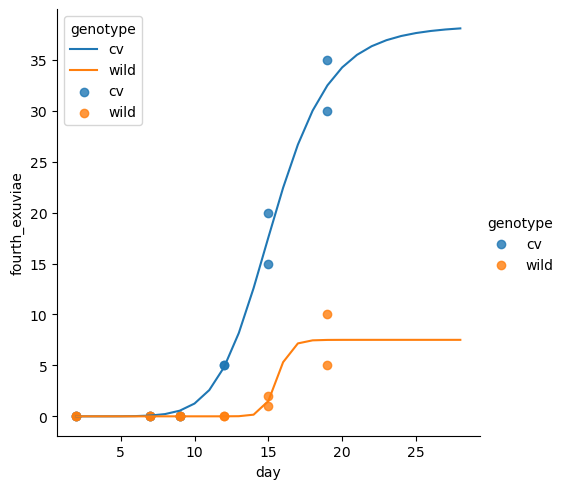

In [45]:



x_line = arange(min(corrected_df.day), max(corrected_df.day), 1)
sns.lmplot(data=corrected_df, x='day', y='fourth_exuviae', hue = 'genotype', fit_reg=False)
sns.lineplot(data=fitted_table, x='day', y='value', hue='genotype')

In [13]:
grouped_df = corrected_df.groupby('sample_id')
max_counts = pd.DataFrame()

for day, group in grouped_df:
    temp_df = group
    temp_df = temp_df.reset_index()
    temp2_df = pd.DataFrame()
    temp2_df = temp_df.nlargest(1, ['fourth_exuviae'])
    temp2_df['egg'] = temp_df['egg'].max()

    max_counts = pd.concat([max_counts, temp2_df], ignore_index=True)

max_counts = max_counts.drop(columns=['index'])
max_counts.head()

stage,sample_id,genotype,day,early_fourth,egg,exuviae,first,late_fourth,second,third,fourth_exuviae,test
0,cv_1,cv,19,10.0,50.0,5.0,0.0,10.0,0.0,5.0,30.0,30.0
1,cv_3,cv,19,10.0,55.0,5.0,0.0,10.0,0.0,5.0,35.0,35.0
2,wild_2,wild,19,8.0,60.0,0.0,2.0,8.0,6.0,10.0,10.0,10.0
3,wild_4,wild,19,6.0,50.0,0.0,1.0,4.0,2.0,7.0,5.0,5.0


In [12]:
class PhenotypeAnalysis:
    '''
    A class to analyse data from developmental bioassays and group the samples in distict phenotypic classes. 
    - What does this class do? 

    Parameters
    ----------
    The constructor method __init__ takes one arguments:
    bioassay_csv: string
        A path to a .csv file with the bioassay count data.
        Shape of the dataframe is usually ...

    Attributes
    ----------
    metabolome_validated: boolean, default=False
      Is the metabolome dataset validated? 
    phenotype_validated=False
    blank_features_filtered=False
    unreliable_features_filtered=False

    '''
    def __init__(
        self, 
        bioassay_csv):

        # Import bioassay dataframe 
        self.bioassay = pd.read_csv(bioassay_csv)



    def reshape_to_wide(
        self,
        sample_id='sample_id',
        grouping_variable='genotype',
        developmental_stages='stage',
        count_values='number',
        time='day'):
        
        '''
        Reshapes the dataframe from a long to a wide format to make the data accessible for pre-processing.
        with the counts of each developmental stage in a seperate columns.
        
        Parameters
        ----------
        sample_id: string, default='sample_id'
            The name of the column that contains the sample identifiers.
        grouping_variable: string, default='genotype'
            The name of the column that contains the names of the grouping variables.
            Examples are genotypes or treatments
        developmental_stages: string, default='stage'
            The name of the column that contains the developmental stages that were scored during the bioassay.
        count_values: string, default='numbers'
            The name of the column that contains the counts.
        time: string, default='day'
            The name of the column that contains the time at which bioassay scoring was performed.
            Examples are the date or the number of days after infection.
        
        Examples
        --------
        Example of an input dataframe

        | sample_id | genotype  | day   | stage         | count |
        |-----------|-----------|-------|---------------|-------|
        | mm_1      |   mm      | 5     | eggs          | 45    |
        | mm_1      |   mm      | 5     | first_instar  | 0     |
        | mm_1      |   mm      | 5     | second_instar | 0     |
        
        
        Example of a reshaped output dataframe

        | sample_id | genotype  | day   | eggs  | first_instar  | second instar | third_instar  |
        |-----------|-----------|-------|-------|---------------|---------------|---------------|
        | mm_1      |   mm      | 5     | 45    | 0             | 0             | 0             |
        | mm_1      |   mm      | 9     | NA    | 10            | 5             | 0             |
        | mm_1      |   mm      | 11    | NA    | 15            | 17            | 4             |
        '''

        
        # check if specified columns exist in dataframe
        if sample_id not in self.bioassay.columns:
            raise ValueError("The specified column with sample identifiers {0} is not present in your '{1}' file.".format(sample_id,os.path.basename(bioassay_csv)))
        else:
            self.sample_id = sample_id

        if grouping_variable not in self.bioassay.columns:
            raise ValueError("The specified column with grouping variable names {0} is not present in your '{1}' file.".format(grouping_variable,os.path.basename(bioassay_csv)))
        else:
            pass

        if developmental_stages not in self.bioassay.columns:
            raise ValueError("The specified column with developmental stages {0} is not present in your '{1}' file.".format(developmental_stages,os.path.basename(bioassay_csv)))
        else:
            pass

        if count_values not in self.bioassay.columns:
            raise ValueError("The specified column with values {0} is not present in your '{1}' file.".format(count_values,os.path.basename(bioassay_csv)))
        else:
            pass

        if time not in self.bioassay.columns:
            raise ValueError("The specified column with time values (e.g. days after infection) {0} is not present in your '{1}' file.".format(time,os.path.basename(bioassay_csv)))
        else:
            pass

        # reshape the dataframe to a wide format with one developmental stage per column
        self.bioassay = self.bioassay.pivot(index=[sample_id, grouping_variable, time], columns=developmental_stages, values=count_values)
        self.bioassay = self.bioassay.reset_index()
        


    def combine_seperately_counted_versions_of_last_recorded_stage(
        self,
        exuviea='exuviea',
        late_last_stage='late_fourth_instar',
        early_last_stage='early_fourth_instar',
        new_last_stage='fourth_instar',
        seperate_exuviea=True,
        late_last_stage_removed=True,
        early_last_stage_kept=True,
        remove_individual_stage_columns=True):
        
        '''
        Calculates the total number of nymphs developed to the final developmental stage per sample on each timepoint.
        This is used when nymphs in the (late) final nymph stage were removed after each counting moment and/or
        when exuviea and last instar stage nymphs were counted seperately.
        Removal of late last stage nymphs could for example be used to prevent adults from emerging and escaping.
        
        Parameters
        ----------
        exuviea: string, default='exuviea'
            The name of the column that contains the exuviea counts. 
        late_last_stage: string, default='late_fourth_instar'
            The name of the column that contains the counts of the last developmental stage recorded in the bioassay.
        early_last_stage: string, default='early_fourth_instar'
            The name of the column that contains the counts of the nymphs in early last developmental stage.
            Is used when nymphs counted in late_last_stage were removed after each counting moment during the bioassay.
        new_last_stage: string, default='fourth_instar'
            Name for new column with the returned total final stage data
        seperate_exuviea: boolean, default=True
            If True, sums exuviea and late_last_stage per sample per timepoint.
            If exuviea were counted seperately from late_last_stage, set to True.
            If exuviea count was included in late_last_stage, set to False
        late_last_stage_removed: boolean, default=True
            If True, returns the cumulative number of late_last_stage(+exuviea) per sample over time.
            If nymphs counted in late_last_stage (and exuviea if counted seperately) were removed after each counting 
            moment, set to True.
            If nymphs counted in late_last_stage (and exuviea if counted seperately) were left on the sample until
            ending the bioassay, set to False.
       early_last_stage_kept: boolean, default=True
            If True, sums the early and late last stage counts per sample per timepoint
            If late last stage nymphs were removed after each counting moment, but early last stage nymphs were left on
            sample, set to True.
            If early and late last stage nymphs were not counted seperately, set to False
        remove_individual_stage_columns: boolean, default=True
            If True, removes exuviea, late_last_stage, early_last_stage columns from dataframe after returning 
            new_last_stage column.
        
        Examples
        --------
        Example of an input dataframe

        | sample_id | genotype  | day   | eggs  | ... | third_instar  | exuviea   | early_fourth_instar | late_fourth_instar |
        |-----------|-----------|-------|-------|-----|---------------|-----------|---------------------|--------------------|
        | mm_1      |   mm      | 5     | 45    | ... | 0             | 0         | 0                   | 0                  |
        | mm_1      |   mm      | 9     | NA    | ... | 0             | 1         | 5                   | 0                  |
        | mm_1      |   mm      | 11    | NA    | ... | 4             | 0         | 7                   | 4                  |
        
        
        Example of an output dataframe

        | sample_id | genotype  | day   | eggs  | first_instar  | second instar | third_instar  | fourth_instar |
        |-----------|-----------|-------|-------|---------------|---------------|---------------|---------------|
        | mm_1      |   mm      | 5     | 45    | 0             | 0             | 0             | 0             |
        | mm_1      |   mm      | 9     | NA    | 10            | 5             | 0             | 6
        | mm_1      |   mm      | 11    | NA    | 15            | 17            | 4             | 12
        '''

        # if the exuviea and late last stage nymphs were counted individualy but treated simmilarly,
        # the exuviea and late last stage nymphs should be summed before going further
        if seperate_exuviea == True:
            
            # check if specified columns with exuviea and late last stage are present
            if exuviea not in self.bioassay.columns:
                raise ValueError("The specified column with exuviea counts {0} is not present in your file.".format(exuviea))
            else:
                pass

            if late_last_stage not in self.bioassay.columns:
                raise ValueError("The specified column with late last stage counts {0} is not present in your file.".format(late_last_stage))
            else:
                pass

            # if specified columns are present, sum exuviea and late last stage
            self.bioassay['late_exuviea'] = self.bioassay[[exuviea, late_last_stage]].sum(axis=1)
        else:
            if late_last_stage not in self.bioassay.columns:
                raise ValueError("The specified column with late last stage counts {0} is not present in your file.".format(late_last_stage))
            else:
                pass
            self.bioassay['late_exuviea'] = self.bioassay[late_last_stage]

        # if the late last stage nymphs were removed after each count, the cumulative number should be used
        # when analysing the development to this stage
        if late_last_stage_removed == True:
            self.bioassay['late_exuviea'] = self.bioassay.groupby([self.sample_id])['late_exuviea'].cumsum()
        else:
            pass

        # if the early last stage nymphs were kept for further development after counting, the early and late last stage
        # nymphs should be combined for the total number of last stage nymphs
        if early_last_stage_kept == True:

            # check if specified column with early last stage counts is present 
            if early_last_stage not in self.bioassay.columns:
                raise ValueError("The specified column with early last stage counts {0} is not present in your file.".format(early_last_stage))
            else:
                pass

            # check if specified column name for total last instar numbers is not yet present 
            if new_last_stage in self.bioassay.columns:
                raise ValueError("The specified column name for total last instar numbers {0} already exists in your file.".format(new_last_stage))
            else:
                pass

            # if only the early last stage column is present, calculate total last stage nymphs
            self.bioassay[new_last_stage] = self.bioassay[['late_exuviea', early_last_stage]].sum(axis=1)
        else:

            # check if specified column name for total last instar numbers is not yet present 
            if new_last_stage in self.bioassay.columns:
                raise ValueError("The specified column name for total last instar numbers {0} already exists in your file.".format(new_last_stage))
            else:
                pass
            self.bioassay[new_last_stage] = self.bioassay['late_exuviea']

        # cleaning up unwanted columns
        if remove_individual_stage_columns == True:
            self.bioassay = self.bioassay.drop(columns=['late_exuviea'])
            self.bioassay = self.bioassay.drop([exuviea, late_last_stage, early_last_stage], axis=1)
        else:
            pass


    def correct_cumulative_counts(
        self, 
        current_stage,
        grouping_variable):
        '''
        Inner function for convert_counts_to_cumulative(). If nymphs die during the bioassay, 
        they should be included in the cumulative count for the stages it had passed. 
        Otherwise, the cumulative count could go down over time. This function corrects the cumulative
        count if it is lower than the previous count.
        '''

        grouped_df = self.bioassay.groupby(grouping_variable)
        corrected_df = pd.DataFrame()

        for day, group in grouped_df:
            temp_df = group
            temp_df = temp_df.reset_index()
            temp_df['test'] = temp_df[current_stage]

            for i in range(1, len(temp_df)):
                if temp_df.loc[i-1, 'test'] != 0:
                    if temp_df.loc[i, 'test'] < temp_df.loc[i-1, 'test']:
                        temp_df.loc[i, 'test'] = temp_df.loc[i-1, 'test']
                    else:
                        pass
                else:
                    pass

            corrected_df = pd.concat([corrected_df, temp_df], ignore_index=True)

        self.bioassay = corrected_df
        self.bioassay[current_stage] = self.bioassay['test']
        self.bioassay = self.bioassay.drop(columns=['test', 'index'])


    def create_df_with_max_counts_per_stage(
        self, 
        egg_column,
        last_stage,
        grouping_variable):
        '''
        Inner function for convert_counts_to_cumulative(). 
        With the maximum number of nymphs developed to or past each developmental stage per plant, 
        making graphs becomes easier.
        '''

        grouped_df = self.bioassay.groupby(grouping_variable)
        self.max_counts = pd.DataFrame()

        for day, group in grouped_df:
            temp_df = group
            temp_df = temp_df.reset_index()
            temp2_df = pd.DataFrame()
            temp2_df = temp_df.nlargest(1, [last_stage])
            temp2_df[egg_column] = temp_df[egg_column].max()

            self.max_counts = pd.concat([self.max_counts, temp2_df], ignore_index=True)

        self.max_counts = self.max_counts.drop(columns=['index'])



    def convert_counts_to_cumulative(
        self,
        n_developmental_stages=4,
        sample_id='sample_id',
        eggs='eggs',
        first_stage='first_instar',
        second_stage='second_instar',
        third_stage='third_instar',
        fourth_stage='fourth_instar',
        fifth_stage='fifth_instar',
        sixth_stage='sixth_instar'):
        
        '''
        Calculates the total number of nymphs developed to or past each stage on each timepoint.
        Cumulative counts make the analysis of development over time and the comparison of number of nymphs past a stage easier.
        If nymphs in the (late) final nymph stage were removed after each counting moment and/or
        when exuviea and/or early and late last instar stage nymphs were counted seperately, 
        total_last_stage() should be used first.
        
        Parameters
        ----------
        n_developmental_stages: integer, default=4
            The number of developmental stage swhich were recorded seperately. 
            Can range from 2 till 6.
        sample_id: string, default='sample_id'
            The name of the column that contains the sample identifiers.
        eggs: string, default='eggs'
            The name of the column that contains the counts of the eggs.
        first_stage: string, default='first_instar'
            The name of the column that contains the counts of the first developmental stage recorded in the bioassay.
        second_stage: string, default='second_instar'
            The name of the column that contains the counts of the second developmental stage recorded in the bioassay.
        third_stage: string, default='third_instar'
            The name of the column that contains the counts of the third developmental stage recorded in the bioassay.
        fourth_stage: string, default='fourth_instar'
            The name of the column that contains the counts of the fourth developmental stage recorded in the bioassay.
        fifth_stage: string, default='fifth_instar'
            The name of the column that contains the counts of the fifth developmental stage recorded in the bioassay.
        sixth_stage: string, default='sixth_instar'
            The name of the column that contains the counts of the sixth developmental stage recorded in the bioassay.
        '''
        
        # check if specified column with sample_id is present 
        if sample_id not in self.bioassay.columns:
            raise ValueError("The specified column with unique sample identifiers {0} is not present in your file.".format(sample_id))
        else:
            pass

        if n_developmental_stages == 1:
            # check if specified columns with counts per stage are present 
            if first_stage not in self.bioassay.columns:
                raise ValueError("The specified column with first stage counts {0} is not present in your file.".format(first_stage))
            else:
                pass


            self.correct_cumulative_counts(current_stage=first_stage, grouping_variable=sample_id)

            self.create_df_with_max_counts_per_stage(egg_column=eggs, last_stage=first_stage, grouping_variable=sample_id)
            
        
        elif n_developmental_stages == 2:

            # check if specified columns with counts per stage are present 
            if first_stage not in self.bioassay.columns:
                raise ValueError("The specified column with first stage counts {0} is not present in your file.".format(first_stage))
            else:
                pass
            if second_stage not in self.bioassay.columns:
                raise ValueError("The specified column with second stage counts {0} is not present in your file.".format(second_stage))
            else:
                pass
            

            # if all specified columns are present, first calculate the cumulative numbers for all stages before 
            # correcting the cumulative counts. Doing it otherwise might increase the risk of double counts.
            self.bioassay[first_stage] = self.bioassay[[first_stage, second_stage]].sum(axis=1)

            self.correct_cumulative_counts(current_stage=second_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=first_stage, grouping_variable=sample_id)

            self.create_df_with_max_counts_per_stage(egg_column=eggs, last_stage=second_stage, grouping_variable=sample_id)

        
        elif n_developmental_stages == 3:
            
            # check if specified columns with counts per stage are present 
            if first_stage not in self.bioassay.columns:
                raise ValueError("The specified column with first stage counts {0} is not present in your file.".format(first_stage))
            else:
                pass
            if second_stage not in self.bioassay.columns:
                raise ValueError("The specified column with second stage counts {0} is not present in your file.".format(second_stage))
            else:
                pass
            if third_stage not in self.bioassay.columns:
                raise ValueError("The specified column with third stage counts {0} is not present in your file.".format(third_stage))
            else:
                pass

            # if all specified columns are present, first calculate the cumulative numbers for all stages before 
            # correcting the cumulative counts. Doing it otherwise might increase the risk of double counts.
            self.bioassay[first_stage] = self.bioassay[[first_stage, second_stage, third_stage]].sum(axis=1)
            self.bioassay[second_stage] = self.bioassay[[second_stage, third_stage]].sum(axis=1)

            self.correct_cumulative_counts(current_stage=first_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=second_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=third_stage, grouping_variable=sample_id)

            self.create_df_with_max_counts_per_stage(egg_column=eggs, last_stage=third_stage, grouping_variable=sample_id)


        
        
        elif n_developmental_stages == 4:

            # check if specified columns with counts per stage are present 
            if first_stage not in self.bioassay.columns:
                raise ValueError("The specified column with first stage counts {0} is not present in your file.".format(first_stage))
            else:
                pass
            if second_stage not in self.bioassay.columns:
                raise ValueError("The specified column with second stage counts {0} is not present in your file.".format(second_stage))
            else:
                pass
            if third_stage not in self.bioassay.columns:
                raise ValueError("The specified column with third stage counts {0} is not present in your file.".format(third_stage))
            else:
                pass
            if fourth_stage not in self.bioassay.columns:
                raise ValueError("The specified column with fourth stage counts {0} is not present in your file.".format(fourth_stage))
            else:
                pass

            # if all specified columns are present, first calculate the cumulative numbers for all stages before 
            # correcting the cumulative counts. Doing it otherwise might increase the risk of double counts.
            self.bioassay[first_stage] = self.bioassay[[first_stage, second_stage, third_stage, fourth_stage]].sum(axis=1)
            self.bioassay[second_stage] = self.bioassay[[second_stage, third_stage, fourth_stage]].sum(axis=1)
            self.bioassay[third_stage] = self.bioassay[[third_stage, fourth_stage]].sum(axis=1)

            self.correct_cumulative_counts(current_stage=first_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=second_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=third_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=fourth_stage, grouping_variable=sample_id)

            self.create_df_with_max_counts_per_stage(egg_column=eggs, last_stage=fourth_stage, grouping_variable=sample_id)


        elif n_developmental_stages == 5:

            # check if specified columns with counts per stage are present 
            if first_stage not in self.bioassay.columns:
                raise ValueError("The specified column with first stage counts {0} is not present in your file.".format(first_stage))
            else:
                pass
            if second_stage not in self.bioassay.columns:
                raise ValueError("The specified column with second stage counts {0} is not present in your file.".format(second_stage))
            else:
                pass
            if third_stage not in self.bioassay.columns:
                raise ValueError("The specified column with third stage counts {0} is not present in your file.".format(third_stage))
            else:
                pass
            if fourth_stage not in self.bioassay.columns:
                raise ValueError("The specified column with fourth stage counts {0} is not present in your file.".format(fourth_stage))
            else:
                pass
            if fifth_stage not in self.bioassay.columns:
                raise ValueError("The specified column with fifth stage counts {0} is not present in your file.".format(fifth_stage))
            else:
                pass

            # if all specified columns are present, first calculate the cumulative numbers for all stages before 
            # correcting the cumulative counts. Doing it otherwise might increase the risk of double counts.
            self.bioassay[first_stage] = self.bioassay[[first_stage, second_stage, third_stage, fourth_stage, fifth_stage]].sum(axis=1)
            self.bioassay[second_stage] = self.bioassay[[second_stage, third_stage, fourth_stage, fifth_stage]].sum(axis=1)
            self.bioassay[third_stage] = self.bioassay[[third_stage, fourth_stage, fifth_stage]].sum(axis=1)
            self.bioassay[fourth_stage] = self.bioassay[[fourth_stage, fifth_stage]].sum(axis=1)

            self.correct_cumulative_counts(current_stage=first_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=second_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=third_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=fourth_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=fifth_stage, grouping_variable=sample_id)

            self.create_df_with_max_counts_per_stage(egg_column=eggs, last_stage=fifth_stage, grouping_variable=sample_id)


        elif n_developmental_stages == 6:

            # check if specified columns with counts per stage are present 
            if first_stage not in self.bioassay.columns:
                raise ValueError("The specified column with first stage counts {0} is not present in your file.".format(first_stage))
            else:
                pass
            if second_stage not in self.bioassay.columns:
                raise ValueError("The specified column with second stage counts {0} is not present in your file.".format(second_stage))
            else:
                pass
            if third_stage not in self.bioassay.columns:
                raise ValueError("The specified column with third stage counts {0} is not present in your file.".format(third_stage))
            else:
                pass
            if fourth_stage not in self.bioassay.columns:
                raise ValueError("The specified column with fourth stage counts {0} is not present in your file.".format(fourth_stage))
            else:
                pass
            if fifth_stage not in self.bioassay.columns:
                raise ValueError("The specified column with fifth stage counts {0} is not present in your file.".format(fifth_stage))
            else:
                pass
            if sixth_stage not in self.bioassay.columns:
                raise ValueError("The specified column with sixth stage counts {0} is not present in your file.".format(sixth_stage))
            else:
                pass

            # if all specified columns are present, first calculate the cumulative numbers for all stages before 
            # correcting the cumulative counts. Doing it otherwise might increase the risk of double counts.
            self.bioassay[first_stage] = self.bioassay[[first_stage, second_stage, third_stage, fourth_stage, fifth_stage, sixth_stage]].sum(axis=1)
            self.bioassay[second_stage] = self.bioassay[[second_stage, third_stage, fourth_stage, fifth_stage, sixth_stage]].sum(axis=1)
            self.bioassay[third_stage] = self.bioassay[[third_stage, fourth_stage, fifth_stage, sixth_stage]].sum(axis=1)
            self.bioassay[fourth_stage] = self.bioassay[[fourth_stage, fifth_stage, sixth_stage]].sum(axis=1)
            self.bioassay[fifth_stage] = self.bioassay[[fifth_stage, sixth_stage]].sum(axis=1)

            self.correct_cumulative_counts(current_stage=first_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=second_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=third_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=fourth_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=fifth_stage, grouping_variable=sample_id)
            self.correct_cumulative_counts(current_stage=sixth_stage, grouping_variable=sample_id)

            self.create_df_with_max_counts_per_stage(egg_column=eggs, last_stage=sixth_stage, grouping_variable=sample_id)

    
    def plot_counts_per_stage(
        self, 
        grouping_variable='genotype',
        sample_id='sample_id',
        eggs='eggs',
        first_stage='first_instar',
        second_stage='second_instar',
        third_stage='third_instar',
        fourth_stage='fourth_instar',
        make_nymphs_relative_to='first_instar'):
        '''
        Plots the counts per nymphal stage in boxplots. The nymph counts are given as the absolute number of nymphs that 
        developed to or past each stage at the last timepoint and as a fraction of nymphs that developed to or past each 
        stage at the last timepoint relative to another developmental stage. The other developmental stage to which the 
        data is made relative defaults to the first instar stage, because this represents the number of hatched eggs. This
        means that in this case only the succes of the development is compared between groups (e.g. genotypes or 
        treatments) and the hatching rate of the eggs is not taken into acount.

        The imput dataframe 'max_counts' is created with convert_counts_to_cumulative.
        
        Parameters
        ----------
        grouping_variable: string, default='genotype'
            The name of the column that contains the names of the grouping variables.
            Examples are genotypes or treatments
        sample_id: string, default='sample_id'
            The name of the column that contains the sample identifiers.
        eggs: string, default='eggs'
            The name of the column that contains the counts of the eggs.
        first_stage: string, default='first_instar'
            The name of the column that contains the counts of the first developmental stage recorded in the bioassay.
        second_stage: string, default='second_instar'
            The name of the column that contains the counts of the second developmental stage recorded in the bioassay.
        third_stage: string, default='third_instar'
            The name of the column that contains the counts of the third developmental stage recorded in the bioassay.
        fourth_stage: string, default='fourth_instar'
            The name of the column that contains the counts of the fourth developmental stage recorded in the bioassay.
        make_nymphs_relative_to: string, default='first_instar'
            The name of the column that contains the counts of the developmental stage which should be used to calculate 
            therelative development to all developmental stages.
        
        Examples
        --------
        Example of an input dataframe

        | sample_id | genotype  | day   | eggs  | first_instar  | second_instar | third_instar | fourth_instar |
        |-----------|-----------|-------|-------|---------------|---------------|--------------|---------------|
        | mm_1      |   mm      | 28    | 45    | 34            | 30            | 30           | 29            |
        | mm_2      |   mm      | 28    | 50    | 39            | 33            | 28           | 26            |
        | LA_1      |   LA      | 28    | 42    | 30            | 25            | 17           | 4             |
        
        '''
        
        self.absolute_counts = pd.DataFrame()
        self.absolute_counts = pd.melt(self.max_counts, id_vars=[sample_id, grouping_variable], 
                value_vars=[eggs, first_stage, second_stage, third_stage, fourth_stage], 
                var_name='developmental_stage', value_name='absolute_count')
        
        plots = sns.FacetGrid(self.absolute_counts, col='developmental_stage')
        plots.map(sns.boxplot, grouping_variable, 'absolute_count', palette="colorblind")
        plots.set(ylim=(0, None))
        
        
        self.max_relative = pd.DataFrame()
        self.max_relative = self.max_counts
        self.max_relative['hatching_rate'] = self.max_relative[first_stage]/self.max_relative[eggs]
        self.max_relative[second_stage] = self.max_relative[second_stage]/self.max_relative[make_nymphs_relative_to]
        self.max_relative[third_stage] = self.max_relative[third_stage]/self.max_relative[make_nymphs_relative_to]
        self.max_relative[fourth_stage] = self.max_relative[fourth_stage]/self.max_relative[make_nymphs_relative_to]

        self.max_relative = pd.melt(self.max_relative, id_vars=[sample_id, grouping_variable], 
                value_vars=['hatching_rate', second_stage, third_stage, fourth_stage], 
                var_name='developmental_stage', value_name='relative_count')
        
        plots = sns.FacetGrid(self.max_relative, col='developmental_stage')
        plots.map(sns.boxplot, grouping_variable, 'relative_count', palette="colorblind")
        plots.set(ylim=(0,1))

        ## I want to add statistics here using an ANOVA with a Dunnett's post-hoc, but at this moment (Nov 1 2022) a Dunnett's
        ## test is not available on python yet. 



    def plot_development_over_time_in_fitted_model(
        self, 
        sample_id='sample_id',
        grouping_variable='genotype',
        time='day',
        stage_of_ineterest='fourth_instar',
        use_relative_data=True,
        make_nymphs_relative_to='first_instar'):
        '''
        Fits a 3 parameter log-logistic curve to the development over time to a specified stage. The fitted curve and the
        observed datapoints are plotted and returned with the model parameters. 
        The reduced Chi-squared is provided to asses the goodness of fit for the fitted models for each group (genotype, 
        treatment, etc.). Optimaly, the reduced Chi-squared should approach the number of observation points per sample. A
        much larger reduced Chi-squared indicates a bad fit. A much smaller reduced Chi-squared indicates overfitting of 
        the model.
        
        Parameters
        ----------
        sample_id: string, default='sample_id'
            The name of the column that contains the sample identifiers.
        grouping_variable: string, default='genotype'
            The name of the column that contains the names of the grouping variables.
            Examples are genotypes or treatments.
        time: string, default='day'
            The name of the column that contains the time at which bioassay scoring was performed.
            Examples are the date or the number of days after infection.
        stage_of_ineterest: string, default='fourth_instar'
            The name of the column that contains the data of the developmental stage of interest.
        use_relative_data: boolean, default=True
            If True, the counts for the stage of interest are devided by the stage indicated at 'make_nymphs_relative_to'.
            The returned relative rate is used for plotting and curve fitting.
        make_nymphs_relative_to: string, default='first_instar'
            The name of the column that contains the counts of the developmental stage which should be used to calculate 
            therelative development to all developmental stages.

        
        Examples
        --------
        Example of an input dataframe

        | sample_id | genotype  | day   | eggs  | first_instar  | second instar | third_instar  | fourth_instar |
        |-----------|-----------|-------|-------|---------------|---------------|---------------|---------------|
        | mm_1      |   mm      | 5     | 45    | 15            | 7             | 0             | 0             |
        | mm_1      |   mm      | 9     | NA    | 24            | 14            | 6             | 3             |
        | mm_1      |   mm      | 11    | NA    | 38            | 27            | 16            | 12            |
        
        '''

        # define function of model:
        def ll3(x,slope,maximum,emt50):
            ''' 
            A three parameter log-logistic function.
        
            Parameters
            ----------
            slope: 
                the slope of the curve
            maximum: 
                the maximum value of the curve
            emt50: 
                the EmT50, the timepoint at which 50% of nymphs has developed to the stage of interest
            '''
            return(maximum/(1+np.exp(slope*(np.log(x)-np.log(emt50)))))
        
        # extract the timecourse in which the bioassay was performed. Needed to fit the model
        x_line = arange(min(self.bioassay[time]), max(self.bioassay[time])+1, 1)

        # if relative counts should be used
        if use_relative_data==True:
            grouped_df = self.bioassay.groupby(sample_id)
            temp_df = pd.DataFrame()
            for name, group in grouped_df:
                temp2_df = group
                temp2_df = temp2_df.reset_index()
                temp2_df['relative_stage'] = temp2_df[stage_of_ineterest]/max(temp2_df[make_nymphs_relative_to])

                temp_df = pd.concat([temp_df, temp2_df], ignore_index=True)

            self.bioassay = temp_df
            self.bioassay = self.bioassay.drop(columns='index')

        else:
            self.bioassay['relative_stage'] = self.bioassay[stage_of_ineterest]


        # add a column with standard deviations to use for the sigma in the curve_fit function
        grouped_df = self.bioassay.groupby([grouping_variable,time])
        stdev_df = pd.DataFrame()
        for name, group in grouped_df:
            temp_df = group
            temp_df = temp_df.reset_index()
            temp_df['stdev'] = temp_df['relative_stage'].std()
            if temp_df['relative_stage'].std() == 0:
                temp_df['stdev'] = 10

            stdev_df = pd.concat([stdev_df, temp_df], ignore_index=True)

        self.bioassay = stdev_df
        self.bioassay = self.bioassay.drop(columns='index')

        # the model is fitted to the individual groups to obtain the parameters for each group:
        grouped_df = self.bioassay.groupby(grouping_variable)
        fit_df = []
        fitted_df = []
        for name,group in grouped_df:
            
            # make an initial guess of the parameters as if the data is linear
            p0 = [-(max(group['relative_stage'])/(max(self.bioassay[time])+1)), max(group['relative_stage']), (max(self.bioassay[time])+1)/2]
            
            # fit the model to the data
            popt, pcov = opt.curve_fit(ll3, group[time], group['relative_stage'], p0=p0)
            
            # store the model parameters with their standard deviations in a df
            temp_df = dict(zip(['slope', 'maximum', 'emt50'], popt))
            temp2_df = dict(zip(['slope_sd', 'maximum_sd', 'emt50_sd'], np.sqrt(np.diag(pcov))))
            temp_df['slope(±sd)'] = '%.2f' % temp_df['slope'] + "(±" + '%.2f' % temp2_df['slope_sd'] + ")"
            temp_df['maximum(±sd)'] = '%.2f' % temp_df['maximum'] + "(±" + '%.2f' % temp2_df['maximum_sd'] + ")"
            temp_df['emt50(±sd)'] = '%.2f' % temp_df['emt50'] + "(±" + '%.2f' % temp2_df['emt50_sd'] + ")"
            temp_df[grouping_variable] = name

            # calculate chi2 for goodness of fit of model
            residuals = group['relative_stage']-ll3(group[time],*popt)
            sq_residuals = residuals**2
            chi_sq = np.sum(sq_residuals / group['stdev']**2)
            temp_df['reduced_chi2'] = chi_sq / 3

            fit_df.append(temp_df)

            # store curve for plotting
            temp3_df = dict(zip(x_line, ll3(x_line, *popt)))
            temp3_df[grouping_variable] = name
            fitted_df.append(temp3_df)


        # print the model parameters and chi2 to manually compare groups
        fit_df = pd.DataFrame(fit_df).set_index(grouping_variable)
        fit_df = fit_df.drop(columns=['slope', 'maximum', 'emt50'])
        print(fit_df)

        
        fitted_df = pd.DataFrame(fitted_df)
        fitted_df = pd.melt(fitted_df, id_vars=grouping_variable, 
                        value_vars=fitted_df.loc[:, fitted_df.columns != grouping_variable], 
                        var_name=time, value_name='value')

        
        # plot the observed data as points and the fitted models as curves
        sns.lmplot(data=self.bioassay, x=time, y='relative_stage', hue = grouping_variable, fit_reg=False, palette="colorblind")
        sns.lineplot(data=fitted_df, x=time, y='value', hue=grouping_variable, palette="colorblind")
        
        self.bioassay = self.bioassay.drop(columns='relative_stage')

# Next: - add statistics to compare groups and return p-values
#       - return sugestion for resistant/susceptible grouping
#       - return df with resistant/susceptible grouping
#       - add more model options
#       - option for choosing model based on best fit
#       - option for prediction if curve is not finished

In [13]:
test = PhenotypeAnalysis("../01_data/test_data/riboflavin_phenotype_data.csv")


In [14]:
test.reshape_to_wide()
test.bioassay.head()

stage,sample_id,genotype,day,0_egg,1_first_instar,2_second_instar,3_third_instar,4_early_fourth_instar,5_late_fourth_instar,6_exuviea
0,LA1840_1,LA1840,2,60.0,0.0,0.0,0.0,0.0,0.0,0.0
1,LA1840_1,LA1840,7,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,LA1840_1,LA1840,9,NaN,4.0,0.0,0.0,0.0,0.0,0.0
3,LA1840_1,LA1840,11,NaN,36.0,0.0,0.0,0.0,0.0,0.0
4,LA1840_1,LA1840,13,NaN,33.0,4.0,0.0,0.0,0.0,0.0


In [15]:
test.combine_seperately_counted_versions_of_last_recorded_stage(exuviea='6_exuviea', late_last_stage='5_late_fourth_instar', early_last_stage='4_early_fourth_instar', seperate_exuviea=True, late_last_stage_removed=True, early_last_stage_kept=True, remove_individual_stage_columns=True)
test.bioassay.head()

stage,sample_id,genotype,day,0_egg,1_first_instar,2_second_instar,3_third_instar,fourth_instar
0,LA1840_1,LA1840,2,60.0,0.0,0.0,0.0,0.0
1,LA1840_1,LA1840,7,NaN,0.0,0.0,0.0,0.0
2,LA1840_1,LA1840,9,NaN,4.0,0.0,0.0,0.0
3,LA1840_1,LA1840,11,NaN,36.0,0.0,0.0,0.0
4,LA1840_1,LA1840,13,NaN,33.0,4.0,0.0,0.0


In [16]:
test.convert_counts_to_cumulative(n_developmental_stages=4, sample_id='sample_id', eggs='0_egg', first_stage='1_first_instar', second_stage='2_second_instar', third_stage='3_third_instar', fourth_stage='fourth_instar')
test.bioassay.head()

stage,sample_id,genotype,day,0_egg,1_first_instar,2_second_instar,3_third_instar,fourth_instar
0,LA1840_1,LA1840,2,60.0,0.0,0.0,0.0,0.0
1,LA1840_1,LA1840,7,NaN,0.0,0.0,0.0,0.0
2,LA1840_1,LA1840,9,NaN,4.0,0.0,0.0,0.0
3,LA1840_1,LA1840,11,NaN,36.0,0.0,0.0,0.0
4,LA1840_1,LA1840,13,NaN,37.0,4.0,0.0,0.0


c:\Users\lisde\anaconda3\envs\sklearn\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\lisde\anaconda3\envs\sklearn\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


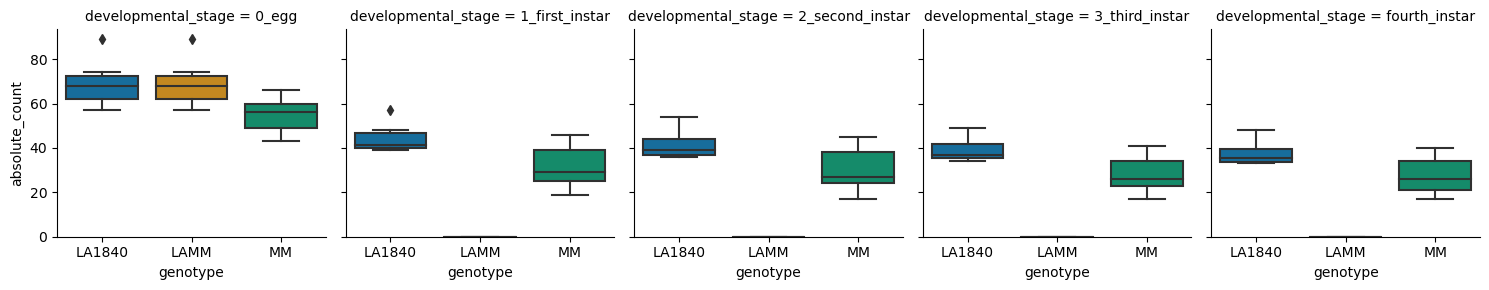

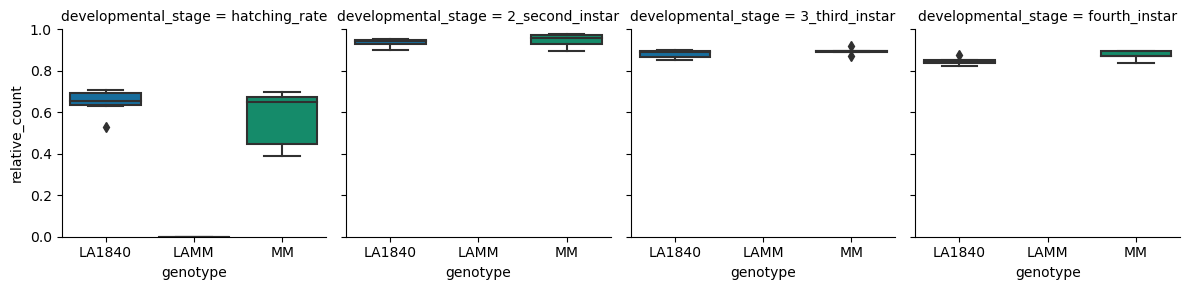

In [10]:
test.plot_counts_per_stage(grouping_variable='genotype', eggs='0_egg', first_stage='1_first_instar', second_stage='2_second_instar', third_stage='3_third_instar', fourth_stage='fourth_instar', make_nymphs_relative_to='1_first_instar')

C:\Users\lisde\AppData\Local\Temp\ipykernel_24456\4171302016.py:685: RuntimeWarning: invalid value encountered in log
  return(maximum/(1+np.exp(slope*(np.log(x)-np.log(emt50)))))
c:\Users\lisde\anaconda3\envs\sklearn\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


             slope(±sd) maximum(±sd)    emt50(±sd)  reduced_chi2
genotype                                                        
LA1840    -13.71(±1.24)  0.84(±0.02)  20.94(±0.16)     14.462679
LAMM        -0.00(±inf)   0.00(±inf)   15.00(±inf)      0.000000
MM        -11.06(±0.99)  0.91(±0.02)  20.31(±0.20)     15.695848


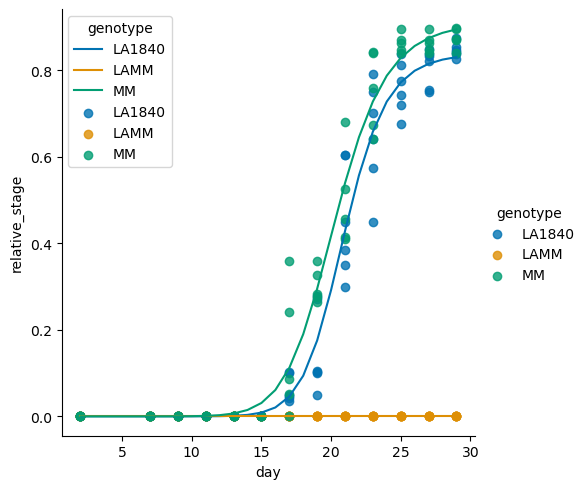

In [17]:
test.plot_development_over_time_in_fitted_model(stage_of_ineterest='fourth_instar', make_nymphs_relative_to='1_first_instar')